In [1]:
%pwd

'/data/Zhaijx/lijz/Some_task/Monosome_project/27_SPARP-seq_github/2_upload_v1/Ribo_nano_project'

## 1. load function

- Loading the public package from python

In [2]:
import sh
from sh import ln

### mapping
from sh import STAR
from sh import bowtie
from sh import bowtie2
from sh import pigz
bowtie_build = sh.Command("bowtie-build")
# bowtie_build2 = sh.Command("bowtie2-build")

In [3]:
import os
import sh
import sys
import glob
import pysam
import importlib
import numpy as np
import pandas as pd
from tqdm import tqdm

In [ ]:
import re
from sh import ln
from sh import samtools
from sh import featureCounts

In [ ]:
import pandas as pd
import numpy as np


- load customed function

In [ ]:
sys.path.append('./Ribo_nano_analysis_tools')

In [ ]:
import Split_fastq as sf
import operating_files as of
import fasta_operation as fop


### cal rpkm
cal_rpkm=sh.Command("cal_rpkm.R")

### analysis diff expression
deseq2 = sh.Command("run_DESeq2.R")

___
## 2. **Cleaning the data**
- Delete `rRNA` and `ChrM`

### 2.1. get ChrM fasta and make index

- using specific format to represent `******_n`

In [ ]:
genome_file = ******_a  ### input genome
genome_dic = fop.get_fasta_dic(genome_file)
chrM_seq = genome_dic["chrM"]

data = f">ChrM\n" + str(chrM_seq)
of.gnf(data.upper(),
       ******_b)   ### output chrM genome

In [ ]:
bt_index_fold = ******_c

bowtie_build("--threads", "24", \
             ******_b, \
             f"{bt_index_fold}/ChrM", \
             _fg = True)

bowtie_build("--threads", "24", \
             "rRNA.fa", \
             "rRNA", \
             _fg=True)


### 2.2. filter the reads mapped to rRNA and ChrM

In [ ]:
rRNA_db = ******_d
chrM_db = ******_e
data_fold = ******_f
data_filter = ******_g

bowtie("-p", "24", \
       "-1", f"{data_fold}/Monosome-RPF-1_R1_001.fastq.gz", \
       "-2", f"{data_fold}/Monosome-RPF-1_R2_001.fastq.gz", \
       "--un", f"{data_filter}/Monosome-RPF-1.del_rRNA.fastq", \
       "-x", rRNA_db, \
       f"{data_filter}/Monosome-RPF-1.del_rRNA.align", \
       _fg = True)

In [ ]:
bowtie("-p", "24", \
       "-1", f"{data_filter}/Monosome-RPF-1.del_rRNA_1.fastq", \
       "-2", f"{data_filter}/Monosome-RPF-1.del_rRNA_2.fastq", \
       "--un", f"{data_filter}/Monosome-RPF-1.del_ChrM.fastq", \
       "-x", chrM_db, \
       f"{data_filter}/Monosome-RPF-1.del_ChrM.align", \
       _fg = True)

___
### 2.3. filtered the reads length
- using the reads length from 25-37 nt

In [ ]:
process_n = 10
out_fold = ******_h

In [4]:
length_used = [x for x in range(25, 37 + 1, 1)]
length_used

[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]

In [ ]:
for _len in tqdm(length_used, total = len(length_used)):
    print(f">>>Start spliting all files, length is {_len}...")
    
    for sample in samples:
        print(f"\t\toperating sample: {sample}")
        _fq = f"{data_filter}/{sample}.del_ChrM.fastq"
        sf.split_func(input_file = _fq, 
                    num_threads = process_n, 
                    output_file = f"{out_fold}/{sample}.len_{_len}.fastq", 
                    seq_len = _len)
    print(f"_"*99)

- using `cat` in linux to merge the fastq results

___
## 3.**Mapping and filter the bam**

### 3.1. mapping by `STAR`

In [ ]:
star_out = ******_h
human_star_index = ******_i

In [5]:
samples = ['Monosome_rep1',
 'Monosome_rep2',
 'Polysome_rep1',
 'Polysome_rep2',
 'Total_rep1',
 'Total_rep2']

In [ ]:
for sample in tqdm(samples, total = len(samples)):
    STAR("--outFilterType", "BySJout", \
        "--runThreadN", "20", \
        "--outFilterMismatchNmax", "2", \
        "--genomeDir", human_star_index, \
        "--readFilesIn", f"{data_filter}/{sample}.merge.fastq", \
        "--outFileNamePrefix", f"{star_out}/{sample}", \
        "--outSAMtype", "BAM", \
        "SortedByCoordinate", "--quantMode", "TranscriptomeSAM", \
        "GeneCounts", "--outFilterMultimapNmax", "1", \
        "--outFilterMatchNmin", "16", \
        "--alignEndsType", "EndToEnd",
        _fg = True)

### 3.3. Retained the uniq bam

In [ ]:
bams = glob.glob("*Aligned.sortedByCoord.out.bam")

In [ ]:
for f in tqdm(fs, total = len(bams)):
    
    _p, _f = os.path.split(f)
    _sample = _f.replace("Aligned.sortedByCoord.out.bam", "")
    
    in_bam = f
    out_bam_uniq = f"{mediate_fold}/{_sample}.raw_uniq.bam"
    out_bam_all = f"{mediate_fold}/{_sample}.raw_withoutunmap.bam"
    
    out_bam_uniq_st = f"{out_fold}/{_sample}.uniq.sorted.bam"
    out_bam_all_st = f"{out_fold}/{_sample}withoutunmap.sorted.bam"
    
    ### get uniq
    samtools("view", "-@", str(num_threads), \
                    "-F", "2308",
                    "-hb", in_bam, \
                    _out=out_bam_uniq)

    samtools("sort", "-@", str(num_threads), \
            "-O", "bam", \
            "-o", out_bam_uniq_st, \
            out_bam_uniq)
    
    ### get all, without unmapped
    samtools("view", "-@", str(num_threads), \
                    "-F", "4",
                    "-hb", in_bam, \
                    _out=out_bam_all)

    samtools("sort", "-@", str(num_threads), \
            "-O", "bam", \
            "-o", out_bam_all_st, \
            out_bam_all)

    ### make index
    samtools("index", "-@", str(num_threads), \
            out_bam_uniq_st)

    samtools("index", "-@", str(num_threads), \
            out_bam_all_st)


### 3.4. Calculate the reads count

In [ ]:
glob.glob(f"{bam_fold}/*uniq.sorted.bam")

In [ ]:
exon_gtf = ******_j
out_fold = ******_k

In [ ]:
featureCounts("-T", 24, \
"-t", "exon", \
"-g", "gene_id", \
"-a", exon_gtf, \
"-o", f"{out_fold}/Uniq_{out_featureCounts}", \
******_list_all_your_uniq_bam)

### 3.5. Calculate the rpkm
- operation the reads count file first

In [ ]:
out_fold = ******_l
_df_f1.to_csv(f"{out_fold}/reads_count.txt",
              sep = "\t",
              index = True,
              quoting = False)

In [ ]:
count_file = f"{out_fold}/reads_count.txt"
rpkm_file = f"{out_fold}/Uniq_rpkm_result.6_sample.txt"
cal_rpkm("--input", count_file,
         "--out", rpkm_file,
         _fg=True)

___
## 4. **Draw metaplot of Ribo-seq**

### 4.1 load the `plot related modules`

In [ ]:
import pickle
from sh import bedtools
from collections import OrderedDict as odt
from collections import defaultdict as dft

### draw function
import matplotlib

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib as mpl
import matplotlib.patches as mp
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

import seaborn as sns

font_dirs = ['./Ribo_nano_analysis_tools/fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

- using of scientific notation

In [ ]:
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0,0))  

- Fundamental algorithms

In [ ]:
from scipy import stats
from statistics import median
from scipy.stats import pearsonr
from scipy.stats import mannwhitneyu
from scipy.interpolate import interpn
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.ndimage import gaussian_filter

- load customed function

In [ ]:
def add_wider(line,
              mode:str = "head",
              n:int = 50):
    """
    mode is head/tail/both
    """
    if mode not in ["head", "tail", "both"]:
        print("Nope! Please try correct")
        return None
    _tl = line.strip().split("\t")
    _s = int(_tl[1])
    _e = int(_tl[2])
    if mode == "head":
        _s = _s - n
    elif mode == "tail":
        _e = _e + n
    else:
        _s = _s - n
        _e = _e + n
    
    _tl_out = [_tl[0], str(_s), str(_e)] + _tl[3:]
    out_line = "\t".join(_tl_out)
    return out_line

def add_no_and_wider(lines,
                     n:int = 50):
    out_lines = ""
    _len = len(lines)
    _strand = lines[0].split("\t")[5]
    
    if _len == 1:
        out_line = add_wider(lines[0], "both", n)
        out_lines = out_line + "\t" + "1_1" + "\n"
    elif _len >= 2:
        for i, _line in enumerate(lines):
            if i == 0:
                _line = add_wider(_line, "head", n)
            elif i == _len -1:
                _line = add_wider(_line, "tail", n)
            else:
                pass
            if _strand == "+":
                _line = _line.strip() + "\t" + f"{i + 1}_{_len}"  + "\n"
            else:
                _line = _line.strip() + "\t" + f"{_len - i}_{_len}"  + "\n"
            out_lines += _line
    return out_lines

In [ ]:
class draw_metaplot(object):

    def __init__(self, bin:int = 50, 
                 out:str = "tmp", 
                 method:str = "Normal", 
                 choose_genes:dict = {}, 
                 col_name:str = "col"):
        
        self.bin = int(bin)
        self.out = str(out)
        self.method = str(method)
        if method not in ["Normal", "Weight"]:
            sys.exit(0)
        self.choose_genes = choose_genes
        self.dic_meta = {}
        all_postions = np.linspace(0, 1000, int(bin) + 1)
        for i, x in enumerate(all_postions[:-1]):
            pos_s, pos_e = str(int(x)), str(int(all_postions[i + 1]))
            str_pos = f'P{pos_s}-{pos_e}'
            self.dic_meta[str_pos] = {"Ratio":[], "Depth":[]}  ### first store ratio; second store depth
        self.col_name = col_name
        
    def gnf(self, data):
        with open(self.out, "w") as fhout:
            fhout.write(data)			
        print(self.out[0].upper() + self.out[1:] + "had generated!")  
        
    def judge_region(self, percentage, strand):
        
        ### judge the postion belongs to which bin, max number of bin is 1000
        def d2s(dec):
            ###decimal to string
            return str(int(round(dec*1000)))

        p = percentage
        a = np.linspace(0, 1, int(self.bin) + 1) ###51could become the "self.bin + 1"
        b, c = a[:-1], a[1:]

        #value_when_true if condition else value_when_false
        p = p+0.000001 if p==0 else p

        return [ "P%s-%s" %(d2s(start), d2s(end)) for start, end in zip(b, c) if start < p <=end][0]

    def get_draw_data(self):
        
        all_postions = np.linspace(0, 1000, int(self.bin) + 1)
        for i, x in enumerate(all_postions[:-1]):
            pos_s, pos_e = str(int(x)), str(int(all_postions[i + 1]))
            str_pos = f'P{pos_s}-{pos_e}'
            self.dic_meta[str_pos] = {"Ratio":[], "Depth":[]}  ### first store ratio; second store depth

        choose_genes = {} ### dic contain genes_dictionary gene_id:(strand, length, POSs, wgA2G)
        
        for gene_id in self.choose_genes.keys():
            gene_info = self.choose_genes[gene_id]
            strand = gene_info["Strand"]
            length = gene_info["length"]
            for pos in gene_info["POSs"].keys():
                ### which bin located 
                ratio, depth = gene_info["POSs"][pos]
                related_pos = float(pos)/float(length)
                bin_mark = self.judge_region(related_pos, strand)
                self.dic_meta[bin_mark]["Ratio"].append(ratio)
                self.dic_meta[bin_mark]["Depth"].append(depth)

        data = []
        for str_pos in self.dic_meta.keys():
            Ratios = self.dic_meta[str_pos]["Ratio"]
            Depths = self.dic_meta[str_pos]["Depth"]
            if self.dic_meta[str_pos]["Ratio"] == []:
                percentage = 0
            else:
                if self.method == "Normal":
                    percentage = float(sum(self.dic_meta[str_pos]["Ratio"]))/float(len(self.dic_meta[str_pos]["Ratio"]))
                elif self.method == "Weight":
                    sum_ratio = sum([r * d for r, d in zip(Ratios, Depths)])
                    sum_dp = sum(Depths)
                    percentage = float(sum_ratio)/float(sum_dp)
            data.append(percentage)
        df = pd.DataFrame({self.col_name: data})
        return df

def lowess_smoothing(x, y, frac:float=0.5, iteration_times:int = 3):
    lowess = sm.nonparametric.lowess(y, x, frac=frac, it=iteration_times)
    return lowess[:, 1]  

In [ ]:
class DataIntegrator:
    def __init__(self, 
                 bin_num=100):
        self.bin = bin_num
        self.bin_edges = np.linspace(0, 1, self.bin + 1)

    def judge_region(self, 
                     percentage):
        bin_index = np.searchsorted(self.bin_edges, percentage, side='left')
        return bin_index

    def integrate_bins(self, 
                       _lists, 
                       mode:str = "Combine"):
        if mode == "Combine":
            self.bin_sums = np.zeros(self.bin, dtype=float)
        elif mode == "Single":
            self.bin_sums = {x:[] for x in range(0, self.bin, 1)}
        self.bin_used_number = np.zeros(self.bin, dtype=int)
        
        for _list in tqdm(_lists, total=len(_lists)):
            n = len(_list)
            if n == 0:
                continue
            for i, _value in enumerate(_list):
                if n == 1:
                    p = 1.0
                else:
                    p = float(i + 1) / float(n)
                p = np.clip(p, 0.000001, 1.0) # decide the zero tp the first bin
                bin_index = self.judge_region(p)
                if mode == "Combine":
                    self.bin_sums[bin_index - 1] += _value
                elif mode == "Single":
                    self.bin_sums[bin_index - 1].append(_value)
                self.bin_used_number[bin_index - 1] += 1
        self.mode = mode

    def get_bin_depths(self):
        if self.mode == "Combine":
            return self.bin_sums.tolist()
        else:
            depths = []
            for x in range(0, self.bin, 1):
                if sum(self.bin_sums[x]) != 0:
                    depth = sum(self.bin_sums[x])/len(self.bin_sums[x])
                else:
                    depth = 0
                depths.append(depth)
            return depths
                
    def get_bin_used_times(self):
        return self.bin_used_number.tolist()

In [ ]:
def tss_tts_metaplot_bins(datain, 
                     ylim_pos, 
                     title_in, 
                     colorin,
                     _svgname):
        # title_in = "MetaPlot"
    plt.figure(figsize=(4.5, 3))

    _y_points = datain
    _x = range(0, 140, 1)

    plt.plot(_x,
                _y_points,
                # marker = "o",
                linestyle = "-",
                linewidth = 3,
                alpha = 0.95,
                color = colorin
                # size = _z,
                # label=_label
                        )

    plt.xticks([0, 20, 53, 86, 120, 140], 
                ["-100", "TSS", "33%", "66%", "TTS", "+100"])

    for pos in [20, 120]:
        plt.axvline(pos,
                    alpha=0.6,
                    color='gray',
                    linewidth = 1,
                    ls="-")   
        
    plt.ylabel('Cover depth')
    plt.xlabel('ORF 5\'->3\'')
    plt.title(title_in.replace("_", " (") + ")", 
              color = colorin,
              size = 15)

    # plt.gca().xaxis.set_major_formatter(formatter)
    plt.gca().yaxis.set_major_formatter(formatter)

    plt.ylim(ylim_pos[0], ylim_pos[1])
    
    # sns.despine(top=True, right=True)
    plt.savefig(_svgname)
    return plt.gcf()

def round_up_to_next(number):
    if number == 0:
        return 0
    magnitude = 10 ** (len(str(int(number))) - 2) 
    return ((number // magnitude) + 1) * magnitude

### 4.2 operating the gtf

In [ ]:
cds_gtf = ******_k

In [ ]:
data = "Chr\tStart\tEnd\tgene_id\tSkip_info\tStrand\ttranscript_id\tprotein_id\n"
data_v2 = "Chr\tStart\tEnd\tgene_id\tSkip_info\tStrand\ttranscript_id\tprotein_id\n"

last_start, last_end, last_gene_id = "0", "0", "_N"
with open(cds_gtf, "r") as fh:
    for line in fh:
        _tl = line.strip().split("\t")
        if _tl[0].startswith("chr"):
            _chr = _tl[0]
            _start = _tl[3]
            _end = _tl[4]
            _strand = _tl[6]
            _info = _tl[8]
            _transcript_id = re.search(r'transcript_id "(.*?)";' ,_info).group(1)
            _gene_id = re.search(r'gene_id "(.*?)";' ,_info).group(1)
            _protein_id = re.search(r'protein_id "(.*?)";' ,_info).group(1)
            
            _start_bed = str(int(_start) - 1)   ### 0-based to 1-based
            
            transcript_id = fao.get_main_id(_transcript_id)
            gene_id = fao.get_main_id(_gene_id)
            protein_id = fao.get_main_id(_protein_id)
            
            uniq_id = "_".join([_start_bed, _end, gene_id])
            last_uniq_id = "_".join([last_start, last_end, last_gene_id])
            if uniq_id == last_uniq_id:
                continue
        else:
            continue
        data += "\t".join([_chr, _start_bed, _end, _gene_id, "1", _strand, _transcript_id, _protein_id]) + "\n"
        data_v2 += "\t".join([_chr, _start_bed, _end, gene_id, "1", _strand, transcript_id, protein_id]) + "\n"
        last_start, last_end, last_gene_id = _start_bed, _end, gene_id
        
out_fold = ******_l
of.gnf(data, f"{out_fold}/gv42.cds.bed")
of.gnf(data_v2, f"{out_fold}/gv42.cds.v1a.bed")

In [ ]:
data = ""
with open(f"{out_fold}/gv42.cds.v1a.bed", "r") as fh:
    dic_gene = {}
    for line in fh:
        _tl = line.strip().split("\t")
        if _tl[0].startswith("chr"):
            _chr = _tl[0]
            _gene = _tl[3]
            _transcript_id = _tl[6]
            if _gene in dic_gene:
                if dic_gene[_gene] == _transcript_id:
                    data += line
                else:
                    continue
            else:
                dic_gene[_gene] = _transcript_id
                data += line

of.gnf(data, f"{out_fold}/gv42.cds.v1b.bed")

- Add ±100bp for the fisrt `CDS` and last `CDS` for eahc gene to draw the meta

In [ ]:
dic_gene = odt()
with open(f"{out_fold}/gv42.cds.v1b.bed", "r") as fh:
    for line in fh:
        _tl = line.strip().split("\t")
        if _tl[0].startswith("chr"):
            _chr = _tl[0]
            _gene = _tl[3]
            _transcript_id = _tl[6]
            dic_gene.setdefault(_gene, []).append(line)

### add 100 and add cds order
data = ""
for k in dic_gene.keys():
    _lines = dic_gene[k]
    data += add_no_and_wider(_lines, 100)
of.gnf(data, f"{out_fold}/gv42.cds.v1d.wd100.bed")

### 4.3.get every cds length

In [ ]:
_df = pd.read_csv(f"{out_fold}/gv42.cds.v1d.wd100.bed",
            sep = "\t",
            header = None,
            index_col = None,
            names = ["Chr", "Start", "End", "Gene_id", "SK", "Strand",
                     "Tr_id", "Pr_id", "Ord"])

_df["orf_id"] = _df["Gene_id"] + "_" + _df["Ord"]
_df["orf_len"] = _df["End"] - _df["Start"]

_df.head(3)

,Chr,Start,End,Gene_id,SK,Strand,Tr_id,Pr_id,Ord,orf_id,orf_len
0,chr1,65464,65573,ENSG00000186092,1,+,ENST00000641515,ENSP00000493376,1_2,ENSG00000186092_1_2,109
1,chr1,69036,70105,ENSG00000186092,1,+,ENST00000641515,ENSP00000493376,2_2,ENSG00000186092_2_2,1069
2,chr1,450642,451778,ENSG00000284733,1,-,ENST00000426406,ENSP00000409316,1_1,ENSG00000284733_1_1,1136


In [ ]:
_df_gb = _df.groupby("Gene_id")
_df_gb_list = _df_gb['orf_id'].apply(list)
gene_orf_dict = _df_gb_list.to_dict()

orf_len_dict = dict(zip(_df["orf_id"], _df["orf_len"]))

gene_orf_len_dict = {}
for k in gene_orf_dict.keys():
    gene_orf_len_dict[k] = {}
    for _orf in gene_orf_dict[k]:
        gene_orf_len_dict[k][_orf] = orf_len_dict[_orf]

- save to pickle

In [ ]:
with open(f"{out_fold}/gene_contain_orf.pickle", 'wb') as f:
    pickle.dump(gene_orf_dict, f)
    
with open(f"{out_fold}/orf_length.pickle", 'wb') as f:
    pickle.dump(orf_len_dict , f)
    
with open(f"{out_fold}/gene_contain_orf_length.pickle", 'wb') as f:
    pickle.dump(gene_orf_len_dict , f)

### 4.4.get coverage information

In [ ]:
bam_fold = ******_your_final_bams_location
ref_fold = ******_your_ref_location

In [ ]:
for _bam in glob.glob(f"{bam_fold}/*.bam"):
    _p, _f = os.path.split(_bam)
    _out = _f.replace("_merge.bam", ".orf.cov.txt")
    samtools("depth", 
         "-@", 24,
         "-b", f"{ref_fold}/gv42.cds.v1d.wd100.bed",
         "-o", f"{filte_out}/{_out}",
         _bam,
         _fg=True)

In [ ]:
samples = ['Monosome_rep1', 'Monosome_rep2', 'Polysome_rep1', 'Polysome_rep2', 'Total_rep1', 'Total_rep2']
out_fold = ******_o
dic_samples_gene_counts = {}

In [ ]:
for sample in samples:
    print(f">>>Start operating {sample} ...<<<")
    
    ### get specific coloumns
    _df = pd.read_csv(f"{fold_orf_cov}/{sample}.orf.cov.txt", 
                sep = "\t",
                header = None,
                names = ["Chr", "End", "Depth"])

    _df["Start"] = _df["End"] - 1
    _df["SK1"] = 1
    _df["SK2"] = 1
    _df["Strand"] = "+"
    _df.head(3)
    _df = _df.loc[:, ["Chr", "Start", "End", "SK1", "SK2", "Strand", "Depth"]]

    _df.to_csv(f"{out_fold}/{sample}.orf.cov.bed", 
            sep = "\t",
            index = False,
            quoting = None,
            header = None)
    
    print(f"\tIntersect between {sample} and cds.bed...")
    bedtools("intersect",
            "-a", f"{out_fold}/{sample}.orf.cov.bed", 
            "-b", f"{ref_fold}/gv42.cds.v1d.wd100.bed",
            "-wao", 
            _out = f"{out_fold}/{sample}.overlaped.orf.mediate.txt")
    
    _df = pd.read_csv(f"{out_fold}/{sample}.overlaped.orf.mediate.txt",
                                sep = "\t", 
                                header=None)
    _df = _df[_df[8] != -1]

    ### transfer the coloumns name
    re_names = dict(zip([0, 8, 9, 6, 1, 5, 10, 15], \
    ["Chr", "cds_start", "cds_end", "depth", "locus", "strand", "gene_id", "orf_id"]))

    _df = _df.loc[:,[0, 8, 9, 6, 1, 5, 10, 15]]
    _df = _df.rename(re_names, axis=1)
    
    _df["gene_orf_id"] = _df["gene_id"] + "_" + _df["orf_id"]
    
    ### get every orf depth counts for every gene    
    print(f"\tCalculate the depth for every gene orf...")
    gene_orf_coverage = dft(list)

    for values in tqdm(_df.values, total = _df.shape[0]):
        (Chr,
        cds_start,
        cds_end,
        depth,
        locus,
        strand,
        gene_id,
        orf_id,
        gene_orf_id) = values

        if not gene_orf_coverage[gene_orf_id]:
            gene_orf_coverage[gene_orf_id] = [0] * (int(cds_end) - int(cds_start))
    
        if strand == "+":
            idx = int(locus) - int(cds_start)
        else:
            idx = abs(int(locus) - int(cds_end))
        gene_orf_coverage[gene_orf_id][idx] += depth
    
    ### combine the orf   
    print(f"\tCombine the orf and save it to the dictionary...")
    cover_genes = list(set(_df.gene_id))
    gene_counts = {}
    for gene in tqdm(cover_genes, total = len(cover_genes)):
        _dic = gene_orf_len_dict[gene]
        _dic_len = len(_dic)
        _keys = [f"{gene}_{_i}_{_dic_len}" for _i in range(1, _dic_len + 1, 1)]
        _depth_list= []
        for _orf_id in _keys:
            if _orf_id in gene_orf_coverage:
                _tl = gene_orf_coverage[_orf_id]
            else:
                _tl = [0] * _dic[_orf_id]
            _depth_list.extend(_tl)
        gene_counts[gene] = _depth_list
        
    dic_samples_gene_counts[sample] = gene_counts
    print(f"_"*30 + f"{sample} is finished"+ f"_"*30 + "\n")

>>>Start operating Monosome_rep1 ...<<<
	Intersect between Monosome_rep1 and cds.bed...
	Calculate the depth for every gene orf...


100%|██████████| 5558088/5558088 [00:28<00:00, 196110.93it/s]


	Combine the orf and save it to the dictionary...


100%|██████████| 12411/12411 [00:00<00:00, 14501.13it/s]


______________________________Monosome_rep1 is finished______________________________

>>>Start operating Monosome_rep2 ...<<<
	Intersect between Monosome_rep2 and cds.bed...
	Calculate the depth for every gene orf...


100%|██████████| 6472114/6472114 [00:35<00:00, 184370.72it/s]


	Combine the orf and save it to the dictionary...


100%|██████████| 12782/12782 [00:00<00:00, 13574.26it/s]


______________________________Monosome_rep2 is finished______________________________

>>>Start operating Polysome_rep1 ...<<<
	Intersect between Polysome_rep1 and cds.bed...
	Calculate the depth for every gene orf...


100%|██████████| 11732729/11732729 [01:01<00:00, 189864.76it/s]


	Combine the orf and save it to the dictionary...


100%|██████████| 14356/14356 [00:01<00:00, 13168.35it/s]


______________________________Polysome_rep1 is finished______________________________

>>>Start operating Polysome_rep2 ...<<<
	Intersect between Polysome_rep2 and cds.bed...
	Calculate the depth for every gene orf...


100%|██████████| 11403726/11403726 [01:01<00:00, 184152.42it/s]


	Combine the orf and save it to the dictionary...


100%|██████████| 14184/14184 [00:01<00:00, 12764.05it/s]


______________________________Polysome_rep2 is finished______________________________

>>>Start operating Total_rep1 ...<<<
	Intersect between Total_rep1 and cds.bed...
	Calculate the depth for every gene orf...


100%|██████████| 13855988/13855988 [01:10<00:00, 196437.31it/s]


	Combine the orf and save it to the dictionary...


100%|██████████| 14390/14390 [00:01<00:00, 13043.95it/s]


______________________________Total_rep1 is finished______________________________

>>>Start operating Total_rep2 ...<<<
	Intersect between Total_rep2 and cds.bed...
	Calculate the depth for every gene orf...


100%|██████████| 14188644/14188644 [01:17<00:00, 183293.96it/s]


	Combine the orf and save it to the dictionary...


100%|██████████| 14542/14542 [00:01<00:00, 12696.29it/s]

______________________________Total_rep2 is finished______________________________



### 4.5.Draw the metaplot
- your could change the `parameters` (colors) for metaplot

In [ ]:
out_fold = "/data/Zhaijx/lijz/Some_task/RiboSeq/6_seq_2025_riboSY/7_coverage/0_splen_bt1/meta_results"
colors = ["#77509a", "#77509a", "#eb8134", "#eb8134", "#4c93c3", "#4c93c3"]
max_ylim = [660000, 910000, 5000000, 4500000, 7800000, 8100000]

color_dict = dict(zip(samples, colors))
ymax_dict = dict(zip(samples, max_ylim))

100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


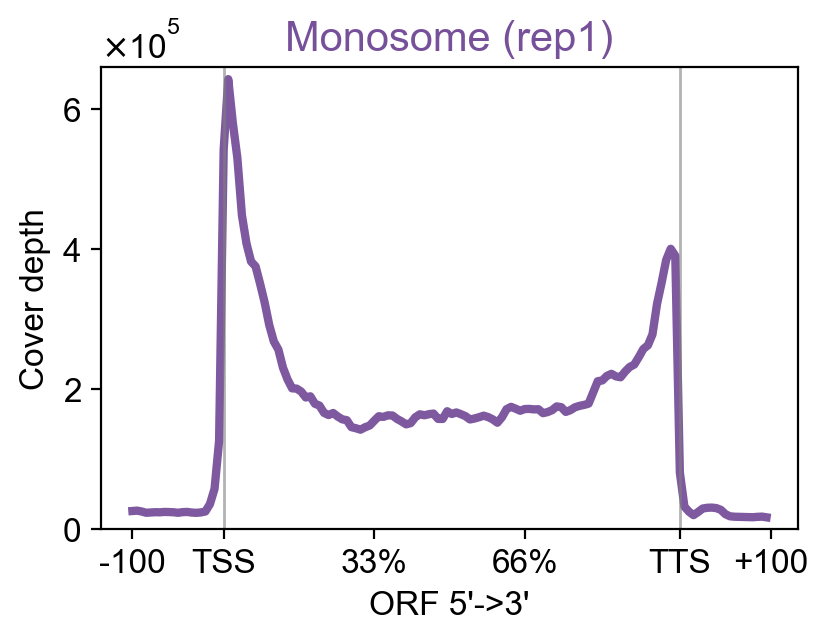

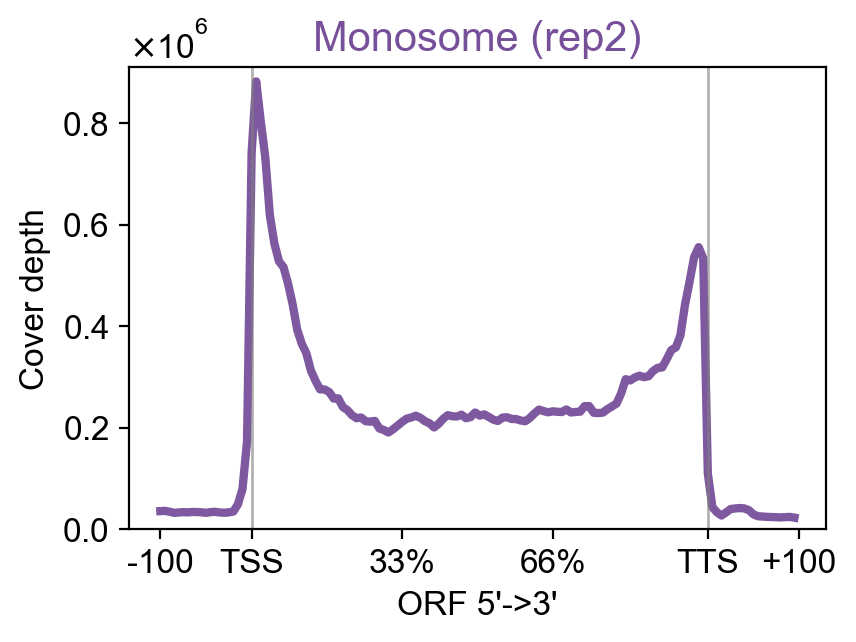

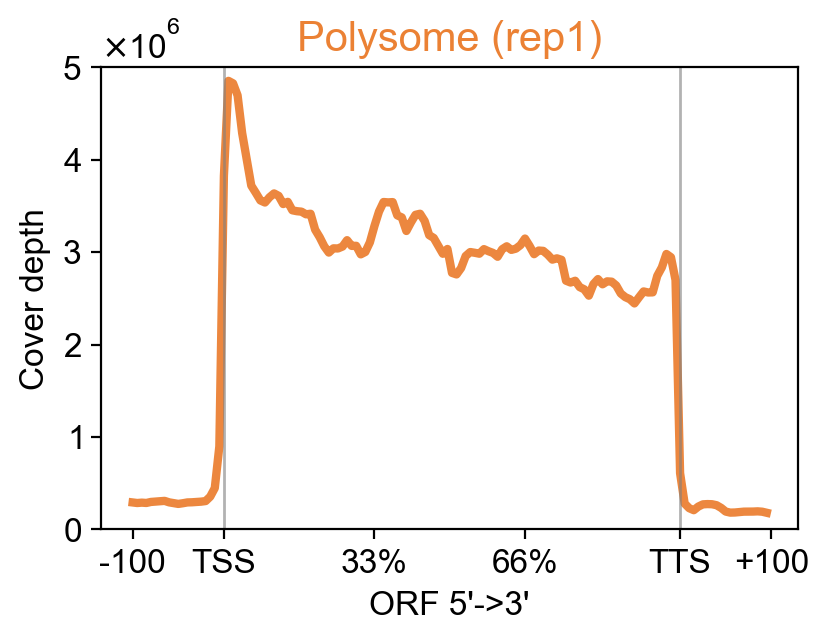

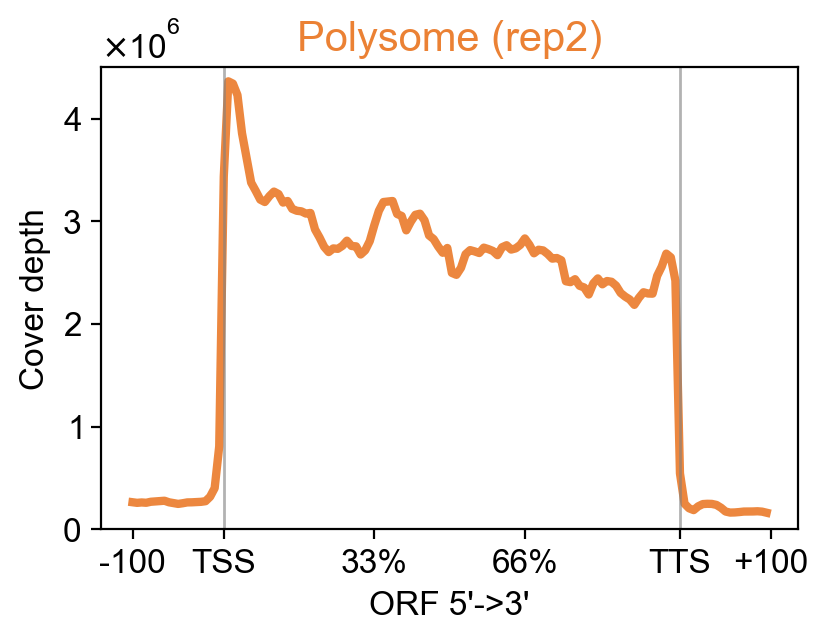

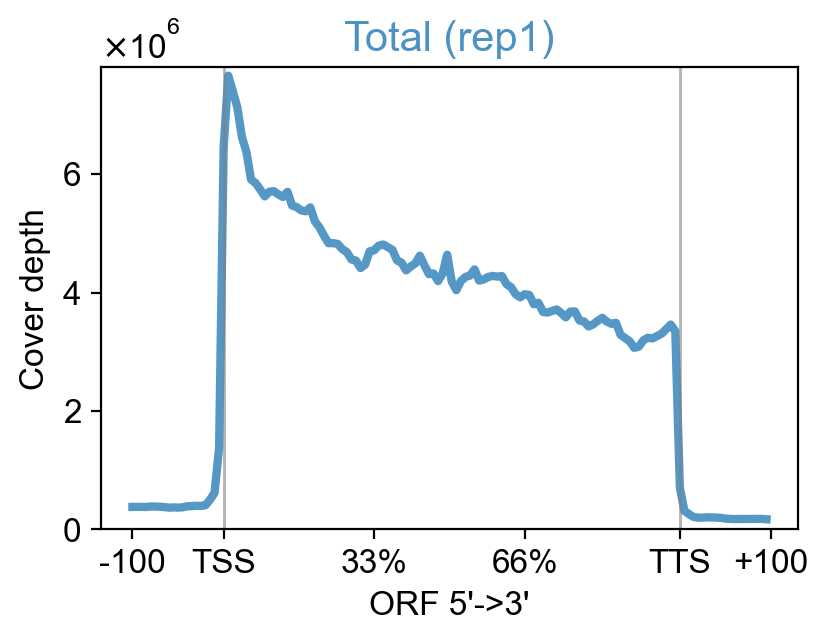

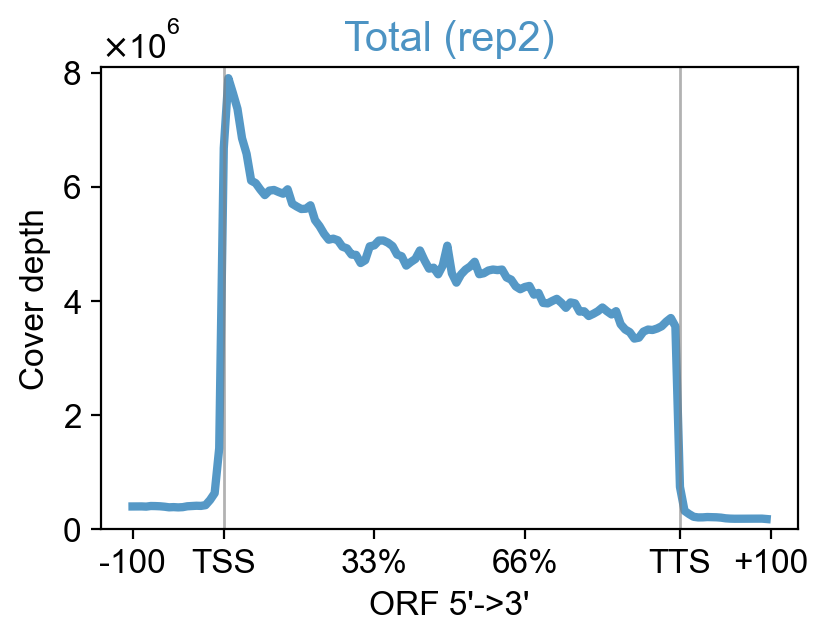

In [ ]:
for sample in tqdm(samples, total = len(samples)):
    _datain = meta_data[sample]
    _datain = gaussian_smoothing(_datain, 0.5)

    tss_tts_metaplot_bins(_datain,
                        [0, ymax_dict[sample]],
                        sample,
                        color_dict[sample],
                        f"{out_fold}/{sample}.Ribo_meta_with_body.svg")
